In this notebook, I extract the broadband flux time series as well as the spectrophometric time series (i.e. the raw transmission spectrum) from our HST data. 

In [1]:
# Importing modules we need:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.convolution as ac
from astropy.io import fits
# Importing HST extraction functions
import HST_Extract_Funcs as hst

I've placed the data in a separate directory off my home directory. Thomas' file structure that loads in the data, however, needs the data held in a directory that branches from the present working directory. Therefore, I'll need to edit this file structure to find where I've placed the data.

If the below block of code is commented out, then I've already done this so skip to next block to load in the new file path structure

In [2]:
# # Load in Thomas' file structure
# FSload = np.load('T_FileStructure.npz', allow_pickle=True)
# data_dict = FSload['filedict'].item()   # dictionary containing paths to the image files

# # Make a deep copy that I can edit
# import copy
# ddcopy = copy.deepcopy(data_dict)
# # Now to edit the paths within the copy dictionary
# for visit in data_dict:
#     # Go through each visit
#     for orbit in data_dict[visit]:
#         # Go through each orbit in that visit
#         #
#         # Each orbit has only one direct image
#         # First, edit this direct image's path
#         oldpath = data_dict[visit][orbit]['direct']
#         newpath = oldpath.replace('./Data/', '/home/matthew/data/hd219666b/hst_images/')
#         ddcopy[visit][orbit]['direct'] = newpath
#         # Now looping through this orbit's grism images and editing their paths
#         grismpaths = data_dict[visit][orbit]['grism']
#         for i, oldpath in enumerate(grismpaths):
#             newpath = oldpath.replace('./Data/', '/home/matthew/data/hd219666b/hst_images/')
#             ddcopy[visit][orbit]['grism'][i] = newpath
            
# # Saving this edited dictionary as the new file structure dictionary
# np.savez('FilePaths.npz', filedict=ddcopy)

Loading in the dictionary containing the file paths to our data

In [3]:
FPload = np.load('FilePaths.npz', allow_pickle=True)
datapaths = FPload['filedict'].item()   # dictionary containing paths to the image files

Defining the dictionary that will hold the resulting extracted data

In [4]:
exdict = {
    'visit1':{
        'orbit1':{
            'spectrum':[ [] for _ in range(len(datapaths['visit1']['orbit1']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit2':{
            'spectrum':[ [] for _ in range(len(datapaths['visit1']['orbit2']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit3':{
            'spectrum':[ [] for _ in range(len(datapaths['visit1']['orbit3']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit4':{
            'spectrum':[ [] for _ in range(len(datapaths['visit1']['orbit4']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]}
    },
   'visit2':{
        'orbit1':{
            'spectrum':[ [] for _ in range(len(datapaths['visit2']['orbit1']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit2':{
            'spectrum':[ [] for _ in range(len(datapaths['visit2']['orbit2']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit3':{
            'spectrum':[ [] for _ in range(len(datapaths['visit2']['orbit3']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit4':{
            'spectrum':[ [] for _ in range(len(datapaths['visit2']['orbit4']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]}
    },
   'visit3':{
        'orbit1':{
            'spectrum':[ [] for _ in range(len(datapaths['visit3']['orbit1']['grism']))],
            'spectrum_uncs':[ [] for _ in range(len(datapaths['visit3']['orbit1']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))],
            'broadband_uncs':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit2':{
            'spectrum':[ [] for _ in range(len(datapaths['visit3']['orbit2']['grism']))],
            'spectrum_uncs':[ [] for _ in range(len(datapaths['visit3']['orbit2']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))],
            'broadband_uncs':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit3':{
            'spectrum':[ [] for _ in range(len(datapaths['visit3']['orbit3']['grism']))],
            'spectrum_uncs':[ [] for _ in range(len(datapaths['visit3']['orbit3']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))],
            'broadband_uncs':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]},
        'orbit4':{
            'spectrum':[ [] for _ in range(len(datapaths['visit3']['orbit4']['grism']))],
            'spectrum_uncs':[ [] for _ in range(len(datapaths['visit3']['orbit4']['grism']))],
            'broadband':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))],
            'broadband_uncs':[ 0 for _ in range(len(datapaths['visit1']['orbit1']['grism']))]}
    },
}

In [45]:
for orbit in datapaths['visit3']:
    # Going through each orbit in the visit
    #    reminder: we're only using visit 3's data
    print('On orbit ', orbit)
    
    ######################################################
    # STEP 1 - Load in the direct image for this orbit
    #          and compute the wavelength solution
    direct_image_path = datapaths['visit3'][orbit]['direct']
    # compute the parameters of the wavelength solution:
    wavesolution = hst.WavelengthSolution(direct_image_path) 
    # find the start & end values of the pixel range over which our spectrum is placed on the image
    #min_wavelength = 11250  # [Angstrom]
    #max_wavelength = 16500  # [Angstrom]
    min_wavelength = 9708   # Min wavelength of response function, [Angstrom]
    max_wavelength = 17904
    dpixelrange = hst.GetExtractRange(min_wavelength, max_wavelength, direct_image_path, 0)
    
    ######################################################
    # STEP 2 - Go through each grism exposure in this orbit
    # Creating some arrays to contain the data of each grism exposure
    Nimages = len(datapaths['visit3'][orbit]['grism'])
    image_1Dspectra = [ [] for _ in range(Nimages)]        # 1D spectra of each image
    image_1Dspectra_uncs = [ [] for _ in range(Nimages)]   # 1D spectral errors of each image
    image_broadbands = np.zeros(Nimages)                   # Band-integrated flux of each image
    image_broadbands_uncs = np.zeros(Nimages)              # Band-integrated flux error of each image
    for image in range(Nimages):
        print('Working on image ',image)
        
        ###################################################
        # STEP 3 - Separate out each sub-exposure within this image
        subexp_details = hst.CreateSubExps(datapaths['visit3'][orbit]['grism'][image], wavesolution)
        subexp_images = subexp_details[0]        # Array containing each sub-exposure's image array
        subexp_times = subexp_details[1]         # Array containing the time of each sub exposure [BJD TDB]
        subexp_badpixmasks = subexp_details[2]   # Array containing each sub-exposure's bad pixel mask
        subexp_dataqualities = subexp_details[3] # Array containing DQ flags on each sub-exposure
        subexp_scandirs = subexp_details[4]      # Array containing the scan direction of each sub-exposure
        subexp_shifts = subexp_details[6]        # Array containing angular shifting of each sub-exposure
        Nsubexps = subexp_images.shape[0]        # Number of sub-exposures in this image
        
        ###################################################
        # STEP 4 - Subtract out the background flux on each sub-exposure image
        bksub_details = hst.BkgdSub(subexp_images, subexp_badpixmasks, subexp_scandirs)
        bsub_subexp_images = bksub_details[0]  # each background subtracted sub-exposure image
        bsub_subexp_bkvals = bksub_details[1]  # background values of each sub-exposure
        bsub_subexp_bkerrs = bksub_details[2]  # uncertainty on above
        
        #*#*#*
        # note: here, I can add in function to set negative pixels to zero
        # will skip for now
        #*#*#*
        
        ###################################################
        # STEP 5 - Flat-field each background subtracted sub-exposure image
        # Path to the appropriate flat-field calibration image:
        flatimg = '/home/matthew/data/hd219666b/calibrations/WFC3.IR.G141.flat.2.fits'
        flat_subexp_images = hst.FlatField(flatimg, bsub_subexp_images, wavesolution, subexp_shifts)
        
        ##################################################
        # STEP 6 - Go through each sub-exposure so we can extract its data
        #          and then combine them into this grism image's data
        # First, need to create some arrays to contain the data of each sub-exposure
        #       for later combining
        subexp_1Dspectra = [ [] for _ in range(Nsubexps)]
        subexp_1Dspectra_uncs = [ [] for _ in range(Nsubexps)]
        subexp_broadbands = np.zeros(Nsubexps)
        subexp_broadbands_uncs = np.zeros(Nsubexps)
        for subexp in range(Nsubexps):

            # Getting this sub-exposure's image (post- flat fielding)
            img = flat_subexp_images[subexp]
            #rawimg = subexp_images[subexp]
            dqimg = subexp_dataqualities[subexp]
            
            ##############################################
            # STEP 7 - Cutting out only the part of the image where the spectrum is...
            # 
            # recall 'dpixelrange' contains the left- and right-most pixel of the spectrum (as floats)
            # guessing the dispersion pixel in the middle of the spectrum, to use to find the y-range of the spectrum
            mid_dpixel = int(np.rint(np.median(dpixelrange)))
            # roughly computing the scan pixel in the middle of the spectrum
            mid_spixel = int(np.rint(np.average(np.arange(img.shape[0]), weights=img[:,mid_dpixel])))
            # defining our cut-out box
            bottom, top = mid_spixel - 20, mid_spixel + 20
            left, right = int(dpixelrange[0] - 10), int(dpixelrange[1] + 10)
            # now cutting out the spectrum
            spec2D = img[bottom:top, left:right]      # the cutout spectrum
            #rawspec2D = rawimg[bottom:top, left:right] 
            dq2D = dqimg[bottom:top, left:right]
            scanpixels = np.arange(spec2D.shape[0])   # pixels along scan axis
            disppixels = np.arange(spec2D.shape[1])   # pixels along dispersion axis            
 
            ###########################################
            # STEP 8 - Correcting bad pixels
            # standard data quality flag values
            # note - some pixels have DQ flags not shown below, as a consequence of
            #        being flagged by multiple affects
            #        the resulting flag is a bitwise addition of the constituent flag values
            dq_flag_vals = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384]
            # these non-standard DQ flags are most present in the spectra
            # so I'll focus only on correcting them!
            
            # I'll run the correction row-by-row (i.e. down the scan direction)
            Nrows = spec2D.shape[0]  # number of scan rows in the cut-out spectrum
                  
            # Plotting the raw cut-out 2D spectrum, pre- background subtraction and pre-flat fielding
            # in order to compare to post-correction
#             print('Subexposure ', subexp)
#             print('Raw 2D spectrum:')
#             plt.imshow(rawspec2D, origin='lower', vmin=0)
#             plt.xlabel('Dispersion pixels')
#             plt.ylabel('Scan pixels')
#             plt.show()
            
            # Now running the correction on the non-standard DQ flagged pixels
            Niters = 5    # number of iterations of correction to run through
                          # multiple iterations helps when bad pixels are grouped together
            for iteration in range(Niters):
                for scanrow in range(Nrows):
                    bad_dq_idxs = np.where(dq2D[scanrow, :] != 0)[0]
                    for bp in bad_dq_idxs:
                        if int(dq2D[scanrow, bp]) not in dq_flag_vals:
                            # We only want those with non-standard flags
                            if int(dq2D[scanrow, bp]) == 48:
                                # There's a lot of non-standard flags of DQ = 48
                                # which aren't causing issues, so ignore them
                                pass
                            else:
                                try:
                                    # Set pixel to the median of pixels above and below it
                                    spec2D[scanrow, bp] = np.median((spec2D[scanrow+1, bp], spec2D[scanrow-1, bp]))
                                except IndexError:
                                    # it'll throw an index error if on the edge of the cut-out image
                                    # in which case, it's a pixel we don't care about
                                    pass
                        else:
                            # If we get a standard flag, ignore it ...
                            pass

#             print('Bkgd subtracted & Flat fielded 2D spectrum')
#             print('Post bad pixel corrections:')
#             plt.imshow(spec2D, origin='lower', vmin=0)
#             plt.xlabel('Dispersion Pixels')
#             plt.ylabel('Scan Pixels')
#             plt.show()
            
            ###########################################
            # STEP 9 - Fitting the spectral trace
            #
            # Array of the scan pixel value of the flux-weighted mean along each dispersion column
            centerlocs = np.zeros((spec2D.shape[1]))
            # getting the scan pixel location of the flux-weighted mean along each dispersion column
            for dpixel in disppixels:
                centerlocs[dpixel] = np.average(scanpixels, weights=spec2D[:,dpixel])
            # fitting a polynomial to these flux-weighted mean locations
            a, m, b = np.polyfit(disppixels, centerlocs, deg=2)
            # computing the spectral trace (i.e. the above polynomial fit)
            spectrace = a*disppixels**2 + m*disppixels + b
        
            ###########################################
            # STEP 10 - Computing the photon noise on each pixel
            # The photon noise = 1 / sqrt(Ncounts) 
            # I'll assume this is the photometric uncertainty on each pixel
            
            img_of_ones = np.ones(spec2D.shape)
            spec2D_uncs = np.sqrt(spec2D) # should this just be sqrt(N) instead???
            # any negative pixels will become Nan uncertainty, so set these to zero
            spec2D_uncs[np.where(np.isnan(spec2D_uncs))] = 0.
            
            
            ############################################
            # STEP 11 - Extracting the 1D spectrum
            # I'll extract the 1D spectrum by summing along each dispersion column
            #     within a box centred upon the spectral trace
            box_halfheight = 14  # extraction box half-height in [pixels] along scan direction
            
            # computing box limits to plot for visualization
            box_low = spectrace - box_halfheight
            box_high = spectrace + box_halfheight
#             print('Spectral Trace and Extraction box:')
#             plt.imshow(spec2D, origin='lower', vmin=0)
#             plt.plot(disppixels, spectrace, c='red', lw=2)
#             plt.plot(disppixels, box_low, ls='--', c='red')
#             plt.plot(disppixels, box_high, ls='--', c='red')
#             plt.xlabel('Dispersion Pixels')
#             plt.ylabel('Scan Pixels')
#             plt.show()            
            
            spec1D = np.zeros(len(disppixels))
            spec1D_uncs = np.zeros(len(disppixels))
            for i, dpixel in enumerate(disppixels):
                # at each dispersion column, sum along the column between the box limits
                box_lowerlim = np.rint(spectrace[i] - box_halfheight)
                box_upperlim = np.rint(spectrace[i] + box_halfheight)
                box = spec2D[int(box_lowerlim):int(box_upperlim), i]
                spec1D[i] = np.sum(box)
                # the uncertainties add in quadrature for this sum
                box_uncs = spec2D_uncs[int(box_lowerlim):int(box_upperlim), i]
                sqr_box_uncs = box_uncs**2
                sum_sqr_box_uncs = np.sum(sqr_box_uncs)
                spec1D_uncs[i] = np.sqrt(sum_sqr_box_uncs)
                
#             print('1D Spectrum:')
#             plt.plot(disppixels, spec1D)
#             plt.xlabel('Dispersion Pixels')
#             plt.ylabel(r'Sum over Scan Column [$e^-$]')
#             plt.show()
            
            # saving orbit 2, image 0, subexposure 0 separately for comparison
            if orbit == 'orbit2' and image == 0 and subexp == 0:
                spec1D_o2i0s0 = spec1D
    
            # Appending this to our collection array
            subexp_1Dspectra[subexp] = np.append(subexp_1Dspectra[subexp], spec1D)
            subexp_1Dspectra_uncs[subexp] = np.append(subexp_1Dspectra_uncs[subexp], spec1D_uncs)
            
            ###########################################
            # STEP 12 - Extracting the broadband flux value and associated photon noise
            broadband = np.sum(spec1D)
            sqr_spec1D_uncs = spec1D_uncs**2
            sum_sqr_spec1D_uncs = np.sum(sqr_spec1D_uncs)
            broadband_unc = np.sqrt(sum_sqr_spec1D_uncs)
            
            
            # appending this to our collection array
            subexp_broadbands[subexp] = broadband
            subexp_broadbands_uncs[subexp] = broadband_unc
            
        #################################
        # STEP 12 - Combining the sub-exposure data
        #     into that of the whole exposure
        # Will do this just by summing them
        # Combining the 1D spectra
        arr_subexp_1Dspectra = np.asarray(subexp_1Dspectra)
        sum_arr_subexp_1Dspectra = np.sum(arr_subexp_1Dspectra, axis=0)  
        image_1Dspectra[image] = sum_arr_subexp_1Dspectra
        
        arr_subexp_1Dspectra_uncs = np.asarray(subexp_1Dspectra_uncs)
        sqr_subexp_1Dspectra_uncs = arr_subexp_1Dspectra_uncs**2
        sum_sqr_subexp_1Dspectra_uncs = np.sum(sqr_subexp_1Dspectra_uncs, axis=0)
        image_1Dspectra_uncs[image] = np.sqrt(sum_sqr_subexp_1Dspectra_uncs)
        
        # Combining the broadband flux
        sum_subexp_broadbands = np.sum(subexp_broadbands)
        image_broadbands[image] = sum_subexp_broadbands
        sqr_subexp_broadbands_uncs = subexp_broadbands_uncs**2
        sum_sqr_subexp_broadbands_uncs = np.sum(sqr_subexp_broadbands_uncs)
        image_broadbands_uncs[image] = np.sqrt(sum_sqr_subexp_broadbands_uncs)
        
        # Appending to results
        exdict['visit3'][orbit]['spectrum'][image] = sum_arr_subexp_1Dspectra
        exdict['visit3'][orbit]['spectrum_uncs'][image] = np.sqrt(sum_sqr_subexp_1Dspectra_uncs)
        exdict['visit3'][orbit]['broadband'][image] = sum_subexp_broadbands
        exdict['visit3'][orbit]['broadband_uncs'][image] = np.sqrt(sum_sqr_subexp_broadbands_uncs)
            


On orbit  orbit1
Working on image  0


<ipython-input-45-6d6140fb2a7d>:166: RuntimeWarning: invalid value encountered in sqrt
  spec2D_uncs = np.sqrt(spec2D) # should this just be sqrt(N) instead???


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16
On orbit  orbit2
Working on image  0


<ipython-input-45-6d6140fb2a7d>:166: RuntimeWarning: invalid value encountered in sqrt
  spec2D_uncs = np.sqrt(spec2D) # should this just be sqrt(N) instead???


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16
On orbit  orbit3
Working on image  0


<ipython-input-45-6d6140fb2a7d>:166: RuntimeWarning: invalid value encountered in sqrt
  spec2D_uncs = np.sqrt(spec2D) # should this just be sqrt(N) instead???


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16
On orbit  orbit4
Working on image  0


<ipython-input-45-6d6140fb2a7d>:166: RuntimeWarning: invalid value encountered in sqrt
  spec2D_uncs = np.sqrt(spec2D) # should this just be sqrt(N) instead???


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16


In [62]:
#exdict['visit3']['orbit4']['spectrum'][1]

In [48]:
# saving the dictionary containing the results
save = True
if save:
    np.savez('reduced_data_dict.npz', dictionary=exdict)

# Looking at the Results & Comparing to Thomas' Reduction

In [46]:
# One of Thomas' sub-exposure 1D spectra
# from orbit 2, image 0, subexposure 0
# needs adjusting to the same range as mine
Tspec = np.loadtxt('thomas_images/1D_Spec_v1.dat', unpack=True, usecols=[0])
Tspecx = np.arange(len(Tspec))[:-1] #+ 20
Tspec = Tspec[:-1]


# I specially saved the 1D spectrum from that subexposure from my pipeline
Cspec = spec1D_o2i0s0[20:]
Cspecx = np.arange(len(Cspec))

frac_diffs = np.zeros(len(Tspecx))
for i, pix in enumerate(Tspecx):
    diff = Cspec[i] - Tspec[i]
    frac_diffs[i] = diff / Cspec[i]
    

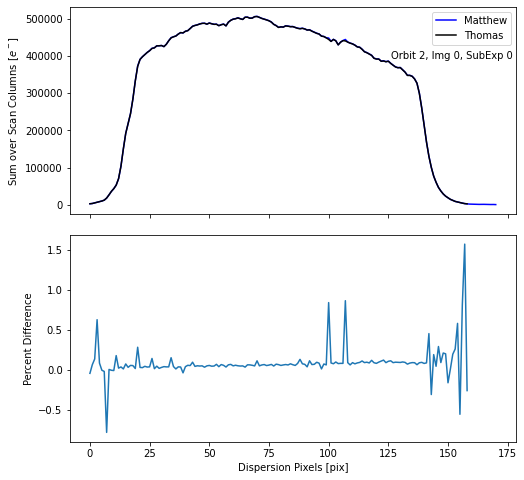

In [47]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
plt.subplots_adjust(hspace=0.1)
ax[0].plot(Cspecx, Cspec, c='blue', label='Matthew')
ax[0].plot(Tspecx, Tspec, c='black', label='Thomas')
#ax[0].set_xlabel('Dispersion Pixels [pix]')
ax[0].set_ylabel(r'Sum over Scan Columns [$e^-$]')
ax[0].text(0.72, 0.75, 'Orbit 2, Img 0, SubExp 0 ', transform=ax[0].transAxes)
ax[0].legend(loc='upper right')
#plt.ylim((4.e6))

ax[1].plot(Tspecx, frac_diffs*100.)
ax[1].set_xlabel('Dispersion Pixels [pix]')
ax[1].set_ylabel('Percent Difference')
plt.show()